In [1]:
import numpy as np
import scanpy as sc
import pandas as pd

import itertools

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

/home/ing/miniconda3/envs/scrna/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
adata = sc.read_h5ad("../visium/aggr/Bladder_Vis_Aggr.h5ad")
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 4344 × 36601
    obs: 'batch', 'batch_num'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'

In [3]:
# Calculate spot neighbors -- can skip 

adata.obs['row'] = np.zeros(adata.shape[0])
adata.obs['col'] = np.zeros(adata.shape[0])
neighbor_barcodes = {}
# library = 'A1'
for library in ['A1', 'B1', 'C1', 'D1']:
    sp = pd.read_csv(f'../visium/Bladder_Vis_{library}/spatial/tissue_positions_list.csv', 
                     index_col=0, header=None)
    sp.index = [f'{library}__' + x.replace('-1', '') for x in sp.index]
    sp = sp.loc[sp.index.isin(adata.obs_names), :]

    row_col = sp.loc[:, [2, 3]].values
    adata.obs.loc[sp.index, 'row'] = sp.loc[:, 2]
    adata.obs.loc[sp.index, 'col'] = sp.loc[:, 3]
    dists = squareform(pdist(row_col, metric='euclidean'))

    for i in range(row_col.shape[0]):
        pt = row_col[i]
        idx = (dists[i,:] <= 2) * (dists[i,:] > 0)
        if idx.sum() < 2: continue
        neighbors = np.squeeze( np.argwhere(idx) )
        neighbor_pt = row_col[neighbors]
        neighbors = neighbors[neighbor_pt[:,1] != pt[1]]
        bc = sp.index[i]
        neighbor_barcodes[bc] = list(sp.index.values[neighbors])

In [4]:
with open('../visium/neighbors_deg1.txt', 'w+') as f:
    for k, v in neighbor_barcodes.items():
        f.write(f'{k}\t' + ','.join(v)+'\n')

In [3]:
!ls ~/devel/ccsig/data/*.csv

/home/ing/devel/ccsig/data/cabello_aguilar_Ligand_Receptor.csv
/home/ing/devel/ccsig/data/cabello_aguilar_LR_PMID.csv
/home/ing/devel/ccsig/data/nichenet_weighted_gr.csv
/home/ing/devel/ccsig/data/nichenet_weighted_lr_sig.csv


In [4]:
lr_table = pd.read_csv('/home/ing/devel/ccsig/data/cabello_aguilar_Ligand_Receptor.csv',
                       index_col=0, header=0)
ligands = np.unique(lr_table.ligand.values)
receptors = np.unique(lr_table.receptor.values)
print(ligands.shape, receptors.shape)

ligands = [l for l in ligands if l in adata.var_names.values]
receptors = [l for l in receptors if l in adata.var_names.values]
adata = adata[:, adata.var_names.isin(ligands + receptors)]

ligands = np.array(ligands)
receptors = np.array(receptors)

print(adata.shape)
print(ligands.shape, receptors.shape)

(807,) (750,)
(4344, 1517)
(793,) (744,)


/home/ing/miniconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [5]:
ligand_expr = adata[:, ligands].X.toarray()
receptor_expr = adata[:, receptors].X.toarray()
full_batch = np.array(adata.obs.batch)
print(ligand_expr.shape, receptor_expr.shape, full_batch.shape)

(4344, 793) (4344, 744) (4344,)


In [13]:
from scipy.stats import spearmanr, pearsonr
min_cor = 0.3
single_corr = []
for i in range(lr_table.shape[0]):
    l, r = lr_table.iloc[i, :].values
    if (l not in ligands) or (r not in receptors):
        continue
    if i % 500 == 0:
        print(i, l, r)
        
#     lx = adata[:, adata.var_names == l].X.toarray().ravel()
#     rx = adata[:, adata.var_names == r].X.toarray().ravel()
    for b in np.unique(adata.obs.batch):
        lx = ligand_expr[full_batch==b, ligands == l]
        rx = receptor_expr[full_batch==b, receptors == r]
        if np.sum(lx) == 0: continue
        if np.sum(rx) == 0: continue

        q = np.quantile(lx, 0.8)
        rq = np.quantile(rx, 0.5)

        # examine receptor expression wherever ligand > 0
#         pct = (rx[lx > rq] > q).mean()
        pct = (rx[lx > 0] > rq).mean()
        if pct > 0.25:
            print(i, l, r, b, pct, len(single_corr))
            single_corr.append((l, r, pct))
            break
print(len(single_corr))

0 A2M LRP1
0 A2M LRP1 A1 0.5025974025974026 0
6 ACTR2 LDLR A1 0.423728813559322 1
8 ADAM10 AXL A1 0.5304878048780488 2
11 ADAM12 ITGB1 A1 0.5675675675675675 3
12 ADAM12 SDC4 A1 0.5743243243243243 4
13 ADAM15 ITGA5 A1 0.4543610547667343 5
15 ADAM15 ITGAV A1 0.5172413793103449 6
16 ADAM15 ITGB1 A1 0.5010141987829615 7
19 ADAM17 ITGA5 A1 0.42366412213740456 8
20 ADAM17 ITGB1 A1 0.5572519083969466 9
21 ADAM17 NOTCH1 C1 0.5743119266055046 10
22 ADAM23 ITGA5 A1 0.3076923076923077 11
30 ADAM9 ITGA3 A1 0.5564102564102564 12
31 ADAM9 ITGA6 A1 0.5538461538461539 13
32 ADAM9 ITGAV A1 0.5205128205128206 14
33 ADAM9 ITGB1 A1 0.5076923076923077 15
34 ADAM9 ITGB5 A1 0.5717948717948718 16
41 ADCYAP1 RAMP2 D1 1.0 17
57 ADM2 RAMP1 A1 0.42857142857142855 18
58 ADM2 RAMP2 D1 0.5 19
59 ADM2 RAMP3 A1 0.5 20
73 ADM RAMP3 A1 0.3166144200626959 21
77 AGRN ITGB1 A1 0.5497630331753555 22
78 AGRN LRP1 A1 0.47393364928909953 23
80 AGRN LRP4 B1 0.5607476635514018 24
95 ALOX5AP ALOX5 A1 0.42857142857142855 25
98 AMH

747 COL4A2 ITGB5 A1 0.5186915887850467 215
748 COL4A3 CD47 A1 0.6956521739130435 216
749 COL4A3 CD93 A1 0.34782608695652173 217
750 COL4A3 ITGA1 A1 0.43478260869565216 218
751 COL4A3 ITGA2 A1 0.6086956521739131 219
752 COL4A3 ITGA3 A1 0.4782608695652174 220
753 COL4A3 ITGAV A1 0.6521739130434783 221
754 COL4A3 ITGB1 A1 0.6521739130434783 222
756 COL4A4 CD47 A1 0.2727272727272727 223
757 COL4A4 CD93 A1 0.6363636363636364 224
758 COL4A4 ITGA1 A1 0.36363636363636365 225
760 COL4A4 ITGAV A1 0.36363636363636365 226
761 COL4A4 ITGB1 A1 0.2727272727272727 227
763 COL4A5 CD47 A1 0.599250936329588 228
764 COL4A5 CD93 A1 0.4419475655430712 229
765 COL4A5 ITGA1 A1 0.45692883895131087 230
766 COL4A5 ITGA2 A1 0.5168539325842697 231
767 COL4A5 ITGAV A1 0.5355805243445693 232
768 COL4A5 ITGB1 A1 0.5131086142322098 233
769 COL4A6 CD47 A1 0.572992700729927 234
770 COL4A6 CD93 A1 0.40875912408759124 235
771 COL4A6 ITGA1 A1 0.4744525547445255 236
772 COL4A6 ITGA2 A1 0.4927007299270073 237
773 COL4A6 ITGA

1253 FGF7 FGFR2 C1 0.2857142857142857 442
1254 FGF7 FGFR3 A1 0.28044280442804426 443
1256 FGF7 NRP1 A1 0.45018450184501846 444
1261 FGF9 FGFR1 A1 0.3333333333333333 445
1262 FGF9 FGFR2 A1 0.3333333333333333 446
1263 FGF9 FGFR3 A1 0.6666666666666666 447
1264 FGF9 FGFR4 D1 0.3333333333333333 448
1275 FN1 CD44 A1 0.50390625 449
1276 FN1 CD79A A1 0.2864583333333333 450
1280 FN1 ITGA2 A1 0.3958333333333333 451
1282 FN1 ITGA3 A1 0.5026041666666666 452
1284 FN1 ITGA5 A1 0.5026041666666666 453
1285 FN1 ITGA6 A1 0.5013020833333334 454
1286 FN1 ITGA8 D1 0.302071973827699 455
1288 FN1 ITGAV A1 0.50390625 456
1289 FN1 ITGB1 A1 0.5026041666666666 457
1291 FN1 ITGB6 A1 0.5013020833333334 458
1293 FN1 ITGB8 C1 0.4774468085106383 459
1295 FN1 NT5E A1 0.4283854166666667 460
1296 FN1 PLAUR A1 0.3971354166666667 461
1298 FN1 SDC2 A1 0.3125 462
1314 FST BMPR2 A1 0.34767025089605735 463
1327 GAS6 AXL A1 0.4816753926701571 464
1346 GDF11 ACVR1B C1 0.3173076923076923 465
1351 GDF11 BMPR2 B1 0.276470588235294

2003 LHB ADRB2 A1 0.3333333333333333 718
2010 LHB RAMP3 B1 0.4 719
2013 LIF IL6ST A1 0.44 720
2014 LIF LIFR B1 0.4444444444444444 721
2015 LIN7C ABCA1 A1 0.40555555555555556 722
2018 LIPC LRP1 A1 1.0 723
2020 LIPH LPAR2 A1 0.3939393939393939 724
2025 LPL CD44 A1 0.5 725
2026 LPL GPIHBP1 D1 0.42857142857142855 726
2027 LPL LRP1 A1 0.4 727
2029 LPL SDC1 A1 0.5 728
2030 LPL VLDLR B1 0.3617021276595745 729
2031 LRP1B PLAUR A1 0.6666666666666666 730
2032 LRPAP1 LDLR A1 0.43313373253493015 731
2033 LRPAP1 LRP1 A1 0.5209580838323353 732
2036 LRPAP1 SORL1 B1 0.3709677419354839 733
2037 LRPAP1 SORT1 A1 0.3932135728542914 734
2038 LRPAP1 VLDLR B1 0.41055718475073316 735
2041 LTA LTBR A1 0.5384615384615384 736
2042 LTA TNFRSF14 A1 0.5384615384615384 737
2043 LTA TNFRSF1A A1 0.5384615384615384 738
2044 LTA TNFRSF1B A1 0.3076923076923077 739
2045 LTBP1 ITGB5 A1 0.550098231827112 740
2046 LTBP3 ITGB5 A1 0.5404858299595142 741
2047 LTB CD40 B1 0.4589041095890411 742
2048 LTB LTBR A1 0.509960159362549

2692 SEMA7A ITGA1 A1 0.4956896551724138 958
2693 SEMA7A ITGB1 A1 0.5948275862068966 959
2695 SERPINA1 LRP1 A1 0.5152671755725191 960
2700 SERPINE1 ITGAV A1 0.5080763582966226 961
2701 SERPINE1 ITGB5 A1 0.5110132158590308 962
2702 SERPINE1 LRP1 A1 0.5110132158590308 963
2704 SERPINE1 PLAUR A1 0.4155653450807636 964
2705 SERPINE2 LRP1 A1 0.5598705501618123 965
2706 SERPING1 LRP1 A1 0.508843537414966 966
2712 SFTPA2 CD93 B1 1.0 967
2713 SFTPD LY96 A1 0.6666666666666666 968
2715 SHANK1 ABCA1 C1 1.0 969
2721 SHBG CLDN4 B1 1.0 970
2723 SHH BOC D1 0.5 971
2731 SLIT1 GPC1 A1 0.6 972
2732 SLIT1 ROBO1 A1 0.4 973
2733 SLIT1 SDC1 A1 0.6 974
2735 SLIT2 GPC1 A1 0.5625 975
2736 SLIT2 ROBO1 B1 0.5652173913043478 976
2739 SLIT2 SDC1 A1 0.5 977
2741 SLPI CD4 B1 0.25766871165644173 978
2742 SORBS1 INSR A1 0.2825112107623318 979
2743 SORBS1 ITGA1 A1 0.4820627802690583 980
2744 SORBS1 ITGB5 A1 0.5582959641255605 981
2745 SOST LRP5 C1 0.5 982
2746 SOST LRP6 C1 0.5 983
2747 SPINK1 EGFR A1 0.5198863636363636 

3113 WNT3A LRP5 A1 0.4 1164
3115 WNT3A RYK A1 0.26666666666666666 1165
3116 WNT3 FZD1 C1 0.6666666666666666 1166
3119 WNT3 FZD8 B1 0.3333333333333333 1167
3120 WNT3 LRP6 B1 0.6666666666666666 1168
3121 WNT3 RYK A1 0.2916666666666667 1169
3122 WNT4 FZD2 A1 0.2641509433962264 1170
3123 WNT4 FZD6 A1 0.33962264150943394 1171
3129 WNT5A FZD6 A1 0.30638297872340425 1172
3131 WNT5A FZD8 B1 0.39552238805970147 1173
3132 WNT5A LDLR A1 0.46808510638297873 1174
3134 WNT5A LRP5 A1 0.26382978723404255 1175
3135 WNT5A MCAM A1 0.548936170212766 1176
3137 WNT5A ROR2 D1 0.3157894736842105 1177
3138 WNT5A RYK A1 0.2680851063829787 1178
3145 WNT7B LRP5 A1 0.25129533678756477 1179
3151 ZG16B CXCR4 A1 0.4117647058823529 1180
3156 ZP3 EGFR A1 0.8333333333333334 1181
3162 VCAM1 MSN A1 0.5229885057471264 1182
3163 VCAM1 EZR A1 0.5 1183
3166 ADAM10 NOTCH1 C1 0.5770440251572327 1184
3167 ADAM10 EFNA3 C1 0.5550314465408805 1185
3169 LGALS8 ITGA3 A1 0.5864978902953587 1186
3170 TIMP3 ADAM17 A1 0.40122199592668023

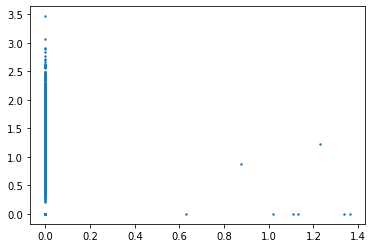

In [10]:
l = 'CD177'
r = 'PECAM1'
lx = adata[:, adata.var_names == l].X.toarray().ravel()
rx = adata[:, adata.var_names == r].X.toarray().ravel()
plt.scatter(lx, rx, s=2)

In [10]:
# Treat the center spot as the ligand source and the surrounding spots as potential receptors
has_neighbors = np.array(neighbor_barcodes.keys())

l_group = np.zeros(( len(neighbor_barcodes), len(ligands)))
r_group = np.zeros(( len(neighbor_barcodes), len(receptors)))
batch = np.zeros(len(neighbor_barcodes), dtype=object)
for i, (k, v) in enumerate(neighbor_barcodes.items()):
    lx = adata[k, ligands].X.toarray()
    rx = np.mean(adata[v, receptors].X.toarray(), axis=0)
    l_group[i, :] = lx
    r_group[i, :] = rx
    batch[i] = k.split('__')[0]

In [11]:
from scipy.stats import spearmanr, pearsonr
min_cor = 0.3
multi_corr = []
for i in range(lr_table.shape[0]):
    l, r = lr_table.iloc[i, :].values
    if (l not in ligands) or (r not in receptors):
        continue
    if i % 500 == 0:
        print(i, l, r)

    lx = l_group[:, ligands == l]
    rx = r_group[:, receptors == r]
    for b in np.unique(batch):
        lx = l_group[batch==b, ligands==l]
        rx = r_group[batch==b, receptors==r]
        if np.var(lx) < 0.2: continue
        if np.sum(lx) == 0: continue
        if np.sum(rx) == 0: continue

        q = np.quantile(lx, 0.8)
        rq = np.quantile(rx, 0.8)

        # examine receptor expression wherever ligand > 0
        pct = (rx[lx > rq] > q).mean()
        if pct > 0.25:
            print(i, l, r, b, pct, len(multi_corr))
            multi_corr.append((l, r, pct))
            break
        
print(len(multi_corr))

0 A2M LRP1
0 A2M LRP1 C1 0.9387755102040817 0
8 ADAM10 AXL D1 0.9401709401709402 1
9 ADAM10 EPHA3 D1 0.35668789808917195 2
13 ADAM15 ITGA5 A1 0.8571428571428571 3
16 ADAM15 ITGB1 A1 1.0 4
19 ADAM17 ITGA5 C1 0.48404255319148937 5
30 ADAM9 ITGA3 C1 0.7755102040816326 6
31 ADAM9 ITGA6 A1 0.4827586206896552 7
33 ADAM9 ITGB1 A1 1.0 8


/home/ing/miniconda3/envs/scrna/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.


78 AGRN LRP1 C1 0.7450980392156863 9
114 ANGPTL4 TIE1 D1 0.5754189944134078 10
166 APOE LRP1 C1 0.3877551020408163 11
175 APP CD74 A1 1.0 12
177 APP GPC1 C1 1.0 13
181 APP NCSTN B1 0.25510204081632654 14
304 C1QB LRP1 C1 0.9722222222222222 15
314 C3 CD81 A1 0.7142857142857143 16
388 CALM1 MYLK A1 0.27906976744186046 17
416 CALM2 MYLK D1 0.6 18
437 CALM3 MYLK A1 0.37735849056603776 19
500 CCL19 ADRA2A
607 CD14 ITGB1 A1 1.0 20
608 CD14 ITGB2 B1 0.3459715639810427 21
615 CD34 SELP D1 0.3105263157894737 22
623 CD55 ADGRE5 D1 0.2980132450331126 23
673 CLCF1 CRLF1 D1 0.5494505494505495 24
674 CLCF1 IL6ST D1 0.9420289855072463 25
675 CLCF1 LIFR D1 0.25824175824175827 26
690 COL14A1 CD44 D1 0.5714285714285714 27
691 COL16A1 ITGB1 A1 1.0 28
692 COL18A1 GPC1 C1 1.0 29
694 COL18A1 ITGA3 C1 0.7232142857142857 30
695 COL18A1 ITGA5 A1 0.6176470588235294 31
696 COL18A1 ITGB1 A1 0.5588235294117647 32
709 COL1A1 ITGA5 D1 0.68 33
743 COL4A1 ITGB1 A1 0.90625 34
747 COL4A2 ITGB5 C1 0.3046594982078853 35
7

3000 VASP CXCR2
3007 VCAN CD44 A1 0.8571428571428571 229
3010 VCAN ITGB1 A1 1.0 230
3019 VEGFA GPC1 C1 1.0 231
3022 VEGFA ITGB1 A1 0.782608695652174 232
3052 VIM CD44 A1 0.3939393939393939 233
3143 WNT7B FZD1 D1 0.41007194244604317 234
3145 WNT7B LRP5 D1 0.697841726618705 235
3166 ADAM10 NOTCH1 D1 0.554140127388535 236
3169 LGALS8 ITGA3 C1 0.95 237
3175 FYN THY1 A1 0.9166666666666666 238
3191 ITGB2 THY1 A1 0.6842105263157895 239
3225 JAG1 CD46 D1 0.9389312977099237 240
241


Text(0.5, 0, 'Ligand ANGPTL4')

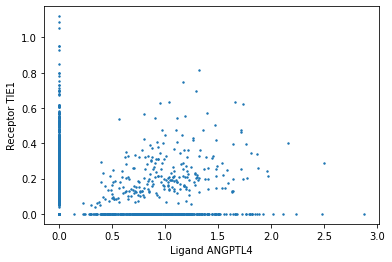

In [12]:
l = 'ANGPTL4'
r = 'TIE1'
lx = l_group[:, ligands==l]
rx = r_group[:, receptors==r]
plt.scatter(lx, rx, s=2)
plt.ylabel(f'Receptor {r}')
plt.xlabel(f'Ligand {l}')

In [11]:
visium_channels = []
for s in single_corr:
    l = s[0]
    r = s[1]
    ch = f'{l}_{r}'
    if ch not in visium_channels:
        visium_channels.append(ch)

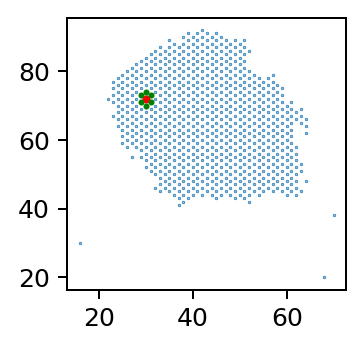

In [14]:
sp = pd.read_csv('../visium/Bladder_Vis_A1/spatial/tissue_positions_list.csv', index_col=0, header=None)
sp.index = [f'A1__' + x.replace('-1', '') for x in sp.index]
sp = sp.loc[sp.index.isin(adata.obs_names), :]

row_col = sp.loc[:, [2, 3]].values
dists = squareform(pdist(row_col, metric='euclidean'))

i = 100
pt = row_col[i]
neighbors = np.squeeze(
    np.argwhere((dists[i,:] <= 2) * (dists[i,:] > 0)) 
)

plt.figure(figsize=(2,2), dpi=180)
plt.scatter(row_col[:,0], row_col[:,1], s=0.1)
plt.scatter(pt[0], pt[1], s=5, color='r')
for nbr in neighbors:
    npt = row_col[nbr]
    if npt[1] == pt[1]: continue
    plt.scatter(npt[0], npt[1], s=2, color='g')
    

In [12]:
with open("visium_channels_2.txt", "w+") as f:
    for c in visium_channels:
        f.write(f'{c}\n')

In [16]:
[k for k in visium_channels if 'NOTCH' in k]

['ADAM17_NOTCH1',
 'DLK2_NOTCH1',
 'DLL1_NOTCH1',
 'DLL1_NOTCH2',
 'DLL1_NOTCH3',
 'DLL1_NOTCH4',
 'DLL4_NOTCH1',
 'JAG1_NOTCH2',
 'JAG1_NOTCH3',
 'JAG1_NOTCH4',
 'JAG2_NOTCH1',
 'JAG2_NOTCH2',
 'JAG2_NOTCH3',
 'MFAP2_NOTCH1',
 'MFAP5_NOTCH1',
 'MFNG_NOTCH1',
 'MFNG_NOTCH2',
 'PSEN1_NOTCH1',
 'PSEN1_NOTCH2',
 'PSEN1_NOTCH3',
 'THBS2_NOTCH3',
 'ADAM10_NOTCH1',
 'DLK1_NOTCH1',
 'DLK1_NOTCH2',
 'DLL3_NOTCH2',
 'DLL4_NOTCH2',
 'DLL4_NOTCH3',
 'DLL3_NOTCH4']

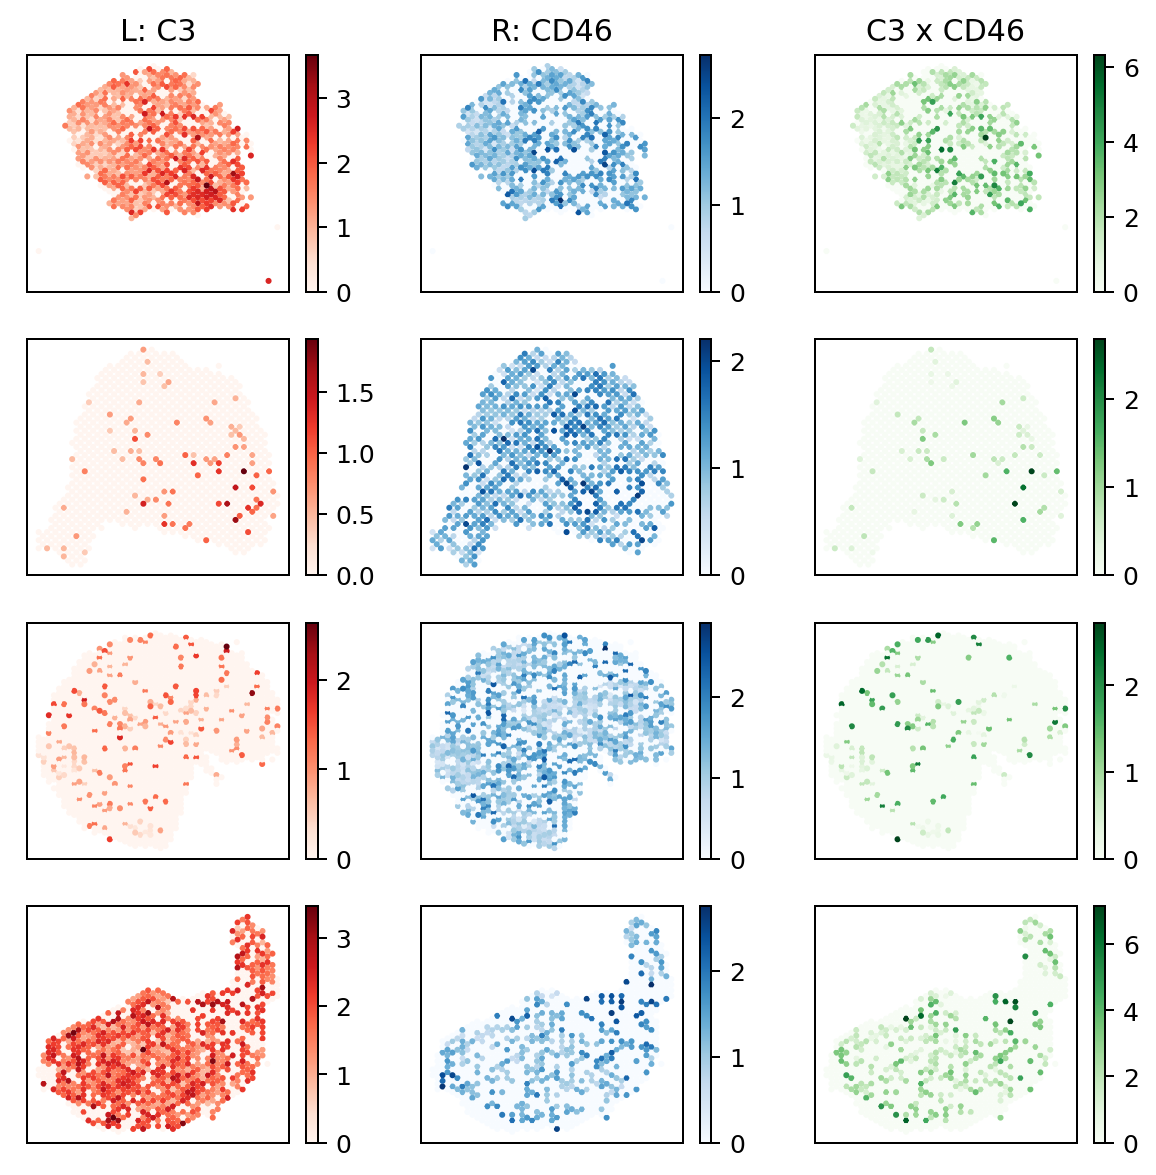

In [25]:
fig, axs = plt.subplots(4, 3, figsize=(8,8), dpi=180)
l = 'C3'
r = 'CD46'


for bx, b in enumerate(np.unique(batch)):
    sp = pd.read_csv(f'../visium/Bladder_Vis_{b}/spatial/tissue_positions_list.csv', index_col=0, header=None)
    sp.index = [f'{b}__' + x.replace('-1', '') for x in sp.index]
    
#     sp = sp.loc[sp.index.isin(has_neighbors), :]
    sp = sp.loc[adata.obs_names[adata.obs.batch == b], :]

    row_col = sp.loc[:, [2, 3]].values

#     lx = l_group[batch==b, ligands==l]
#     rx = r_group[batch==b, receptors==r]
    lx = ligand_expr[full_batch==b, ligands==l]
    rx = receptor_expr[full_batch==b, receptors==r]
    
    v = lx * rx
    srt = np.arange(len(v))
#     srt = np.argsort(v)

    cm = axs[bx, 0].scatter(row_col[srt,0], row_col[srt,1], s=2, c=lx[srt], cmap='Reds')
    plt.colorbar(cm , ax = axs[bx, 0])
    cm = axs[bx, 1].scatter(row_col[srt,0], row_col[srt,1], s=2, c=rx[srt], cmap='Blues')
    plt.colorbar(cm , ax = axs[bx, 1])
    cm = axs[bx, 2].scatter(row_col[srt,0], row_col[srt,1], s=2, c=v[srt], cmap='Greens')
    plt.colorbar(cm , ax = axs[bx, 2])

for t, ax in zip([f'L: {l}', f'R: {r}', f'{l} x {r}'], axs[0]):
    ax.set_title(t)
for ax in axs.ravel():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
plt.savefig(f'02_Filter_Ligand_Receptor_coincidence/{l}_{r}.png', bbox_inches='tight')